Investigate the property derivative variation in the PHX space and how interval of P/H/X affect the derivation result.

In [1]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'  #default font family
mpl.rcParams['mathtext.fontset'] = 'cm' #font for math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from iapws import IAPWS97
import iapws

import pyswEOS
from pyswEOS import H2ONaCl
from pyswEOS import H2O
from pyswEOS import NaCl
water=H2O.cH2O()
sw=H2ONaCl.cH2ONaCl()
halite=NaCl.cNaCl()
figpath='.'
fmt_figs = ['jpg','svg','pdf']
path_echarts='../../manual/sphinx/source/Benchmarks/echarts/'

## Constant P and X, variable H

In [87]:
p, X_wt = 300E5, 0.032
H = np.linspace(200, 4000, 1000)*1000 #J/kg
Rho = np.zeros_like(H)
phaseRegion = np.zeros_like(H)
dRhodH = {}
dH_list = [1] #kJ/kg
for dH in dH_list:
    dRhodH[dH] = np.zeros_like(H)
for i in range(0, len(H)):
    prop = sw.prop_pHX(p, H[i], X_wt)
    Rho[i] = prop.Rho
    phaseRegion[i] = prop.Region
    for dH_kJ in dH_list:
        dH = float(dH_kJ)*1E3 #J/kg
        prop2 = sw.prop_pHX(p, H[i] + dH/2.0, X_wt)
        prop1 = sw.prop_pHX(p, H[i] - dH/2.0, X_wt)
        dRhodH[dH_kJ][i] = (prop2.Rho - prop1.Rho)/dH


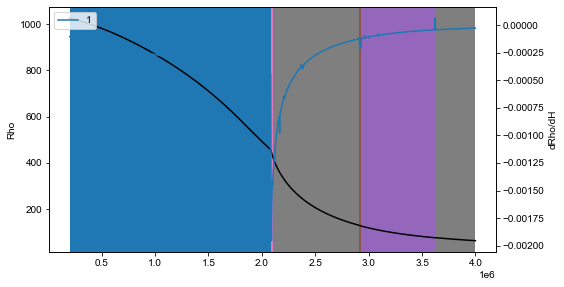

In [98]:
fig = plt.figure(figsize=(8, 4.5))
ax  = plt.gca()

ax.plot(H, Rho,'k')
ax.set_ylabel('Rho')
for i in range(1,len(phaseRegion)):
    ax.axvspan(H[i-1], H[i], fc = plt.cm.tab10.colors[int(phaseRegion[i])], ec='None')

ax_der = ax.twinx()
for i, dH in enumerate(dH_list):
    ax_der.plot(H, dRhodH[dH], ms=1, label=dH)
# ax_der.set_ylim(-0.0015, 0)
ax_der.set_ylabel('dRho/dH')
ax_der.legend()

plt.savefig('dRhodH.pdf', bbox_inches='tight')
plt.show()

### Test drho/dH of H2O using both formula and numerical difference methods
* Formula of $\left(\frac{\partial \rho}{\partial h}\right)_p = \left[ \left( \frac{\partial h}{\partial \rho} \right)_T - \left( \frac{\partial h}{\partial T} \right)_{\rho}\left( \frac{\partial p}{\partial \rho} \right)_T\left( \frac{\partial p}{\partial T} \right)_{\rho}^{-1} \right]^{-1}$, see [Thorade & Saadat (2013)](https://doi.org/10.1007/s12665-013-2394-z)
* All the derivatives inside the square brackets are already implemented in the [IAPWS95](https://iapws.readthedocs.io/en/latest/iapws.iapws95.html) python package. (dhdrho_T, dhdT_rho, dpdrho_T, dpdT_rho)

In [101]:
p = 30 # MPa
water=iapws.IAPWS95(T=1 + 273.15, P=30)
print(water.h)
water=iapws.IAPWS95(h=1500, P=p)
print(water.h, water.dhdrho_T, water.dhdT_rho, water.dpdrho_T, water.dpdT_rho)

33.94976586940974
1499.9999999999172 -0.6024177412086003 4.372360502197804 0.43334763458006287 0.9649333655996997


In [102]:
H = np.linspace(200, 4000, 100) #kJ/kg
Rho = np.zeros_like(H)
dRhodH = {}
dH_list = [1E-9, 1E-5, 1, 10] #kJ/kg
dRhodH_formula = np.zeros_like(H)
for dH in dH_list:
    dRhodH[dH] = np.zeros_like(H)
for i in range(0, len(H)):
    water=iapws.IAPWS95(h=H[i], P=p)
    Rho[i] = water.rho
    dRhodH_formula[i] = 1.0/(water.dhdrho_T - water.dhdT_rho * water.dpdrho_T / water.dpdT_rho)
    for dH_kJ in dH_list:
        dH = float(dH_kJ) #kJ/kg
        water2=iapws.IAPWS95(h=H[i]+dH/2, P=p)
        water1=iapws.IAPWS95(h=H[i]-dH/2, P=p)
        dRhodH[dH_kJ][i] = (water2.rho - water1.rho)/dH

/Users/zguo/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/iapws/iapws95.py:2125: RuntimeWarning: invalid value encountered in double_scalars
  Tita = Tita**(1./3)
/Users/zguo/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/iapws/iapws95.py:2156: RuntimeWarning: invalid value encountered in double_scalars
  Tita = Tita**(1./3)


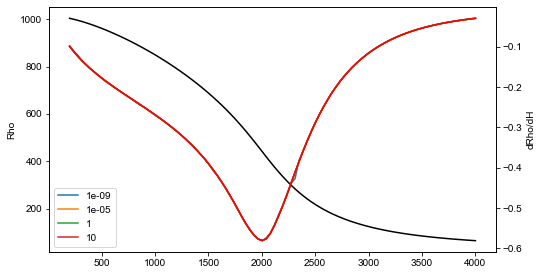

In [103]:
fig = plt.figure(figsize=(8, 4.5))
ax  = plt.gca()

ax.plot(H, Rho,'k')
ax.set_ylabel('Rho')

ax_der = ax.twinx()
for i, dH in enumerate(dH_list):
    ax_der.plot(H, dRhodH[dH], ms=1, label=dH)
ax_der.plot(H, dRhodH_formula, 'r')
# ax_der.set_ylim(-0.0015, 0)
ax_der.set_ylabel('dRho/dH')
ax_der.legend()

plt.savefig('dRhodH_water.pdf', bbox_inches='tight')
plt.show()